In [4]:
import os
import pandas as pd
import numpy as np
import ants
import itk
import SimpleITK as sitk
import matplotlib.pyplot as plt
import ants
import dicom2nifti



In [5]:
cn_dict_with_images = np.load("data/cn_dict_with_images.npy",allow_pickle='TRUE').item()
ad_dict_with_images = np.load("data/ad_dict_with_images.npy",allow_pickle='TRUE').item()
smci_dict_with_images = np.load("data/smci_dict_with_images.npy",allow_pickle='TRUE').item()
pmci_dict_with_images = np.load("data/pmci_dict_with_images.npy",allow_pickle='TRUE').item()

In [6]:
example_path = '/Volumes/Extreme SSD/ADNI/002_S_0295/MP-RAGE/2006-04-18_08_20_30.0/I13722/'

example_image = itk.imread(example_path)

#ants_example_image = ants.image_read(example_path)

**Borrowed the following code from Lucas**

In [7]:
def show_slices(slices,img):
    """ Function to display row of image slices """
    fig, axes = plt.subplots(1, len(slices))
    fig.set_size_inches(11,8)
    for i, slice in enumerate(slices):

        axes[i].imshow(slice.T, cmap="gray", origin="lower")
    plt.suptitle(f"Center slices for current MRI image \n Image size: {img.shape}",fontsize=20)
    # print("image size:",img.shape)
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.20)
    plt.show()

def show_brain_center_slice(img: np.memmap):
    slice_0 = img[int(img.shape[0]/2), :, :]
    slice_1 = img[:, int(img.shape[1]/2), :]
    slice_2 = img[:, :, int(img.shape[2]/2)]
    show_slices([slice_0, slice_1, slice_2],img)

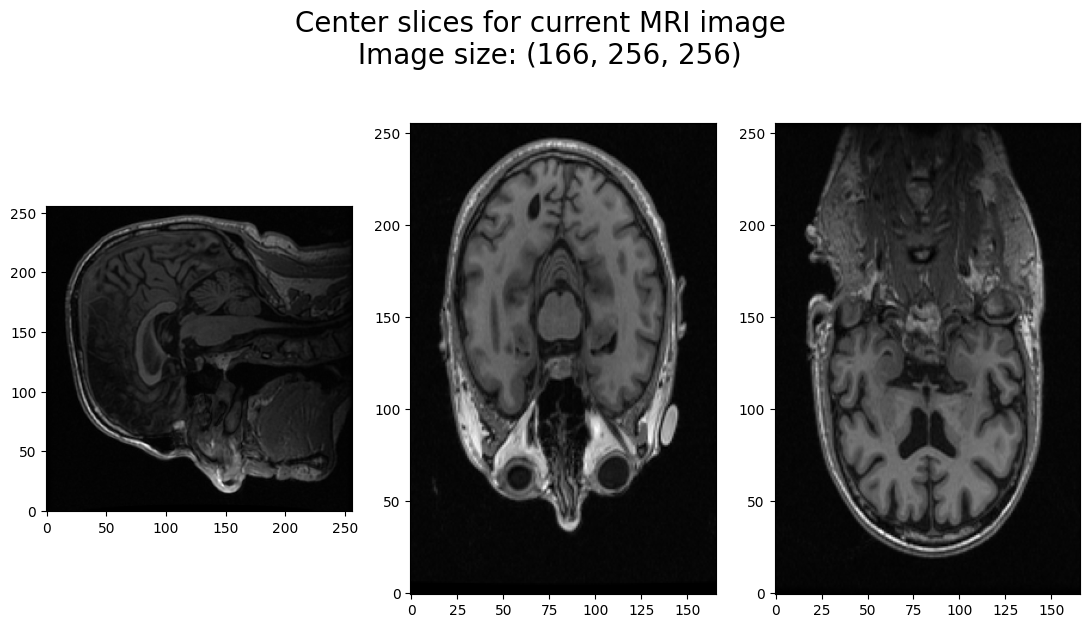

In [8]:
show_brain_center_slice(example_image)

In [17]:
corrected_image = itk.n4_bias_field_correction_image_filter(example_image)

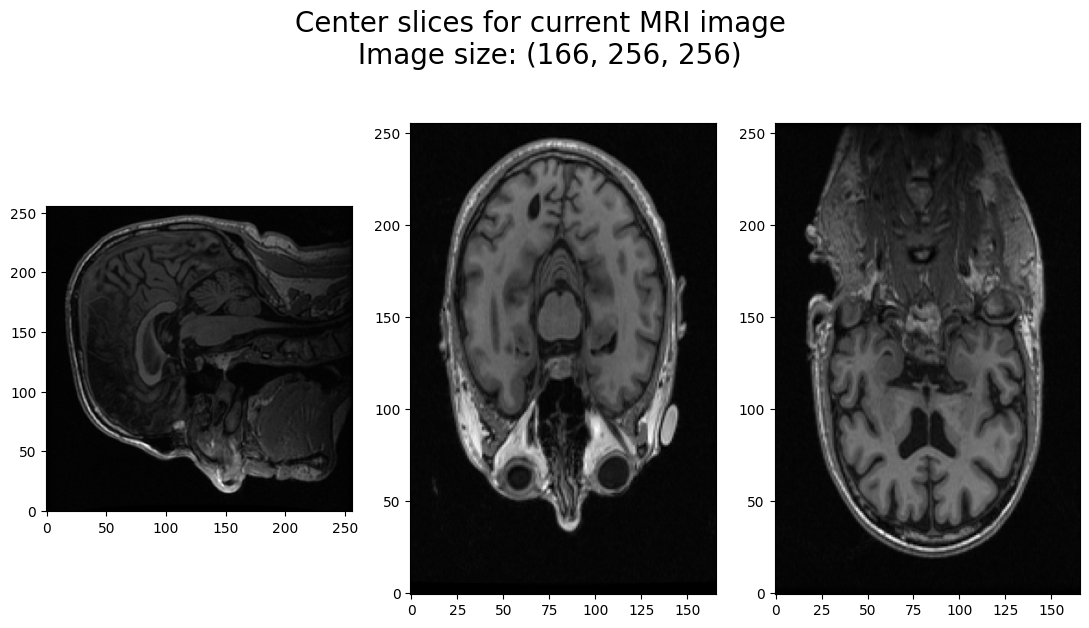

In [10]:
show_brain_center_slice(corrected_image)

In [11]:
#reader = sitk.ImageSeriesReader()
#dicom_names = reader.GetGDCMSeriesFileNames('/Volumes/Extreme SSD/ADNI/002_S_0295/MP-RAGE/2006-04-18_08_20_30.0/I13722/')
#reader.SetFileNames(dicom_names)
#image = reader.Execute()

#image = sitk.GetImageFromArray(test_arr)

# Added a call to PermuteAxes to change the axes of the data
itk_image = corrected_image

new_sitk_image = sitk.GetImageFromArray(itk.GetArrayFromImage(itk_image), isVector=itk_image.GetNumberOfComponentsPerPixel()>1)
new_sitk_image.SetOrigin(tuple(itk_image.GetOrigin()))
new_sitk_image.SetSpacing(tuple(itk_image.GetSpacing()))
new_sitk_image.SetDirection(itk.GetArrayFromMatrix(itk_image.GetDirection()).flatten()) 

new_sitk_image = sitk.PermuteAxes(new_sitk_image, [2, 1, 0])

sitk.WriteImage(new_sitk_image, 'M0_1.nii.gz')

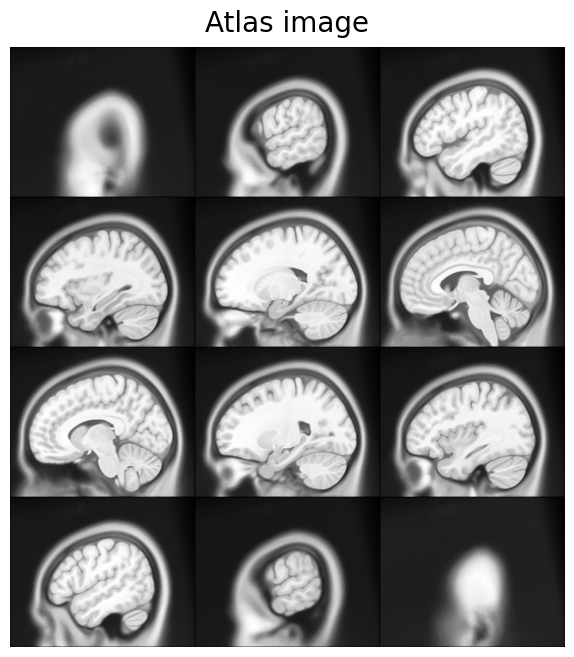

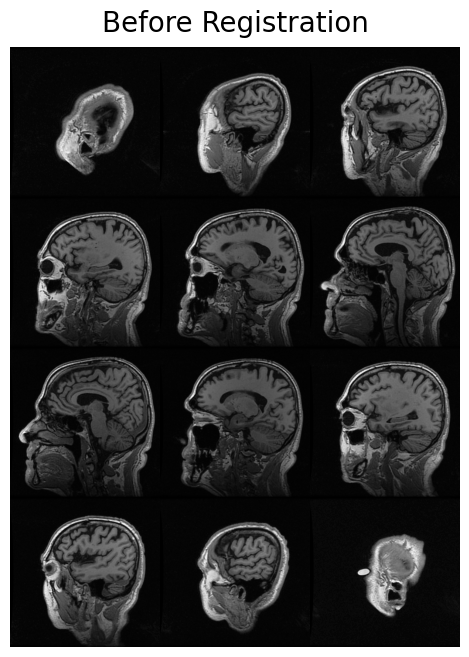

In [12]:
mi = ants.image_read("M0_1.nii.gz")

fi = ants.image_read('//Users/olath/Downloads/mni_icbm152_nlin_sym_09a_nifti/mni_icbm152_nlin_sym_09a/mni_icbm152_t1_tal_nlin_sym_09a.nii')
fi.plot(title='Atlas image')
mi.plot(title='Before Registration')

mytx = ants.registration(fixed=fi, moving=mi, type_of_transform = 'SyN' )


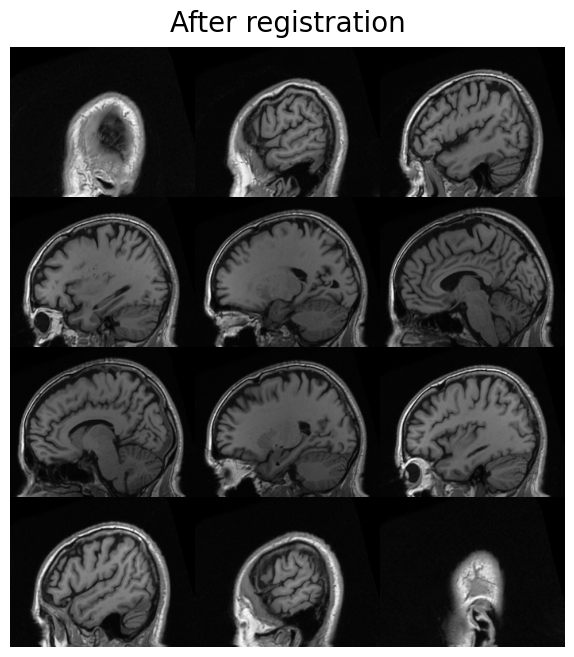

In [13]:
mywarpedimage = ants.apply_transforms(fixed=fi, moving=mi,
                                      transformlist=mytx['fwdtransforms'])

mywarpedimage.plot(title='After registration')

In [14]:
center_dim = [int(np.ceil(x/2)) for x in mywarpedimage.shape]
lower_dim = [int(x - 50) for x in center_dim]
upper_dim = [int(x + 50) for x in center_dim]

cropped_image =  ants.crop_indices(mywarpedimage,lowerind = lower_dim,upperind = upper_dim)

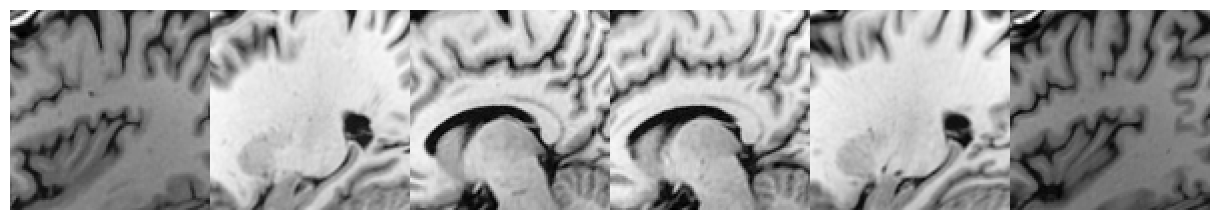

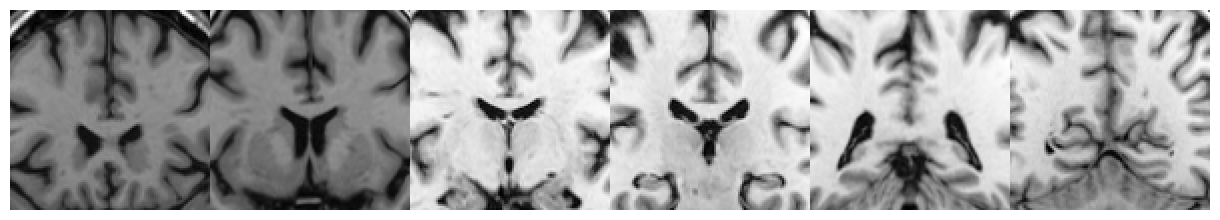

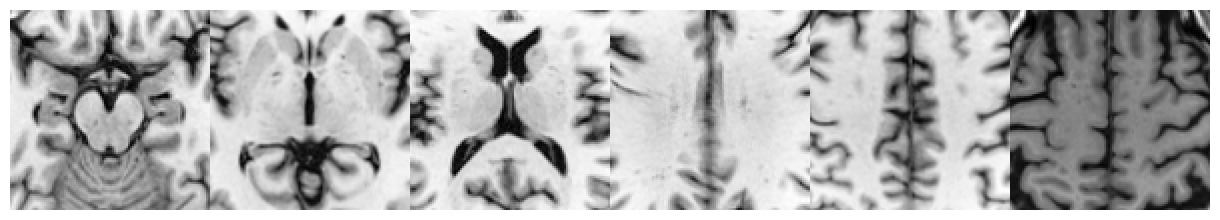

In [15]:
cropped_image.plot(axis =0,figsize=2,nslices=6)
cropped_image.plot(axis =1,figsize=2,nslices=6)
cropped_image.plot(axis =2,figsize=2,nslices=6)

In [16]:
ants.image_write(cropped_image,"cropped.nii.gz")